In [1]:
from src.setup import *
from src import viral_seq
from src import common
from src import host
%load_ext autoreload
%autoreload 2

# Plan

1. Reminder 
1. Clinical data
1. Viral data
1. Viral PCA
1. Host genotype data

# Clinical data

Description: 725 individuals, 21 variables. 

In [2]:
df_clinical_raw = pd.read_csv(PATH_CLINICAL_RAW_DATA)
print("number of variables:", len(df_clinical_raw.columns))
df_clinical_raw.columns

number of variables: 21


Index(['IGM_ID', 'Viral_Sequencing_Status', 'AVG_COVERAGE', 'USUBJID',
       'STUDYID', 'SUBJID', 'Screening ID', 'GT', 'COUNTRY', 'ETHNICITY',
       'RACE', 'SEX', 'AGE', 'OAV_EXPERIENCE', 'BASELINE_HBEAG_STATUS',
       'BASELINE_BMI', 'BASELINE_ALT_U/L', 'BASELINE_HBSAG_log10_IU/mL',
       'BASELINE_HBVDNA_IU/mL', 'BASELINE_HBVDNA_Dil_IU/mL', 'gilead_id'],
      dtype='object')

Plots:
* Histogram of age
* Barplot of viral genotypes
* 

In [3]:
with open(PATH_CLINICAL_DATA, 'rb') as file :
    df_clinical = pickle.load(file)

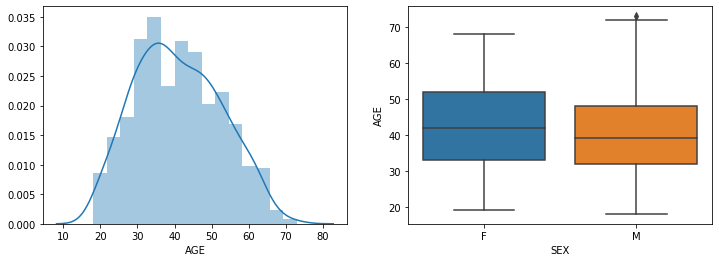

In [35]:
fig,ax = plt.subplots(1,2,figsize=(12,4))
sns.distplot(df_clinical.AGE.dropna(), ax=ax[0]);
sns.boxplot(x='SEX', y='AGE', data=df_clinical);

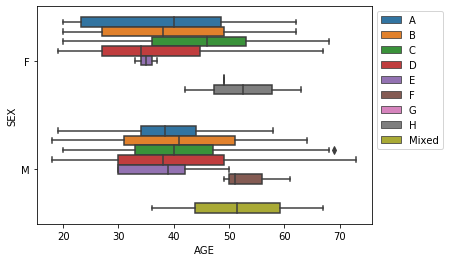

In [101]:
sns.boxplot(x='AGE', y='SEX', data=df_clinical, hue='GT');
plt.gca().legend(bbox_to_anchor=(1,1));

In [6]:
# Create the palette for viral genotypes to keep consistent colors
default_palette = sns.color_palette()
GTs = df_clinical.GT.value_counts().index.values
gt_palette = {}
for i, gt in enumerate(GTs):
    gt_palette[gt] = default_palette[i]

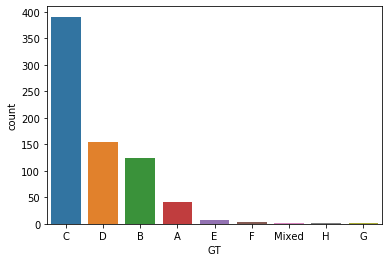

In [7]:
sns.countplot(x='GT', data=df_clinical, order=GTs, palette=gt_palette);

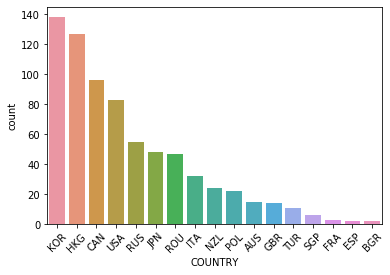

In [39]:
order = df_clinical.COUNTRY.value_counts().index.values
sns.countplot(x='COUNTRY', data=df_clinical, order=order)
plt.xticks(rotation=45);

In [15]:
df_clinical.RACE.value_counts()
df_clinical.RACE.cat.rename_categories({'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER':'Hawaiian', 'ASIAN':'Asian',
                                       'WHITE':'White', 'BLACK OR AFRICAN AMERICAN':'Black / African american',
                                       'OTHER':'Other', }, 
                                       inplace=True)
df_clinical.RACE.value_counts()

Asian                       534
White                       174
Black / African american     10
Hawaiian                      5
Other                         2
Name: RACE, dtype: int64

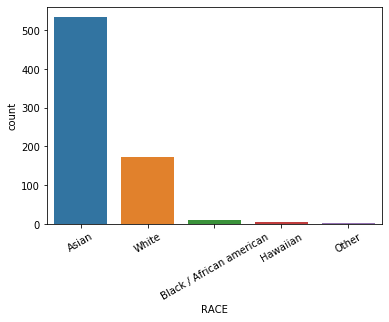

In [61]:
sns.countplot(x="RACE", data=df_clinical, order=df_clinical.RACE.value_counts().index.values);
plt.xticks(rotation=30);

In [55]:
df_stack = df_clinical.groupby(['COUNTRY', 'RACE']).size().reset_index().pivot(columns='RACE', index='COUNTRY', values=0)

In [78]:
# Reorder the rows by the sum of individuals in each country
df_stack = df_stack.loc[df_stack.sum(axis=1).sort_values(ascending=False).index.values]

In [93]:
# Reorder the columns to be consistent with the plot on above
df_stack = df_stack[['Asian', 'White', 'Black / African american', 'Hawaiian', 'Other']]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text xticklabel objects>)

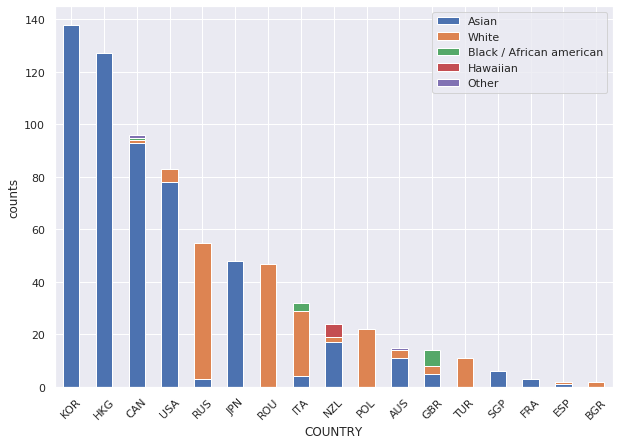

In [103]:
df_stack.plot(kind='bar', stacked=True, figsize=(10,7))
plt.gca().legend(bbox_to_anchor=(1,1))
plt.ylabel("counts");
plt.xticks(rotation=45)

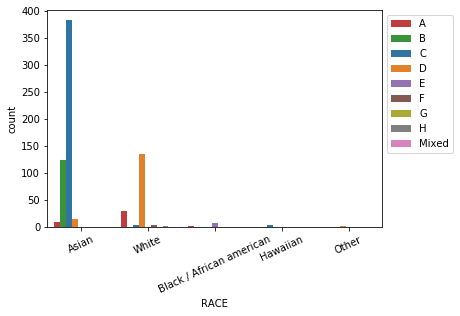

In [95]:
sns.countplot(x='RACE', hue='GT', data=df_clinical, order=df_clinical.RACE.value_counts().index.values, 
              palette=gt_palette);
plt.gca().legend(bbox_to_anchor=(1,1))
plt.xticks(rotation=25);

In [160]:
df_stack = df_clinical.groupby(['GT', 'RACE']).size().reset_index().pivot(columns='GT', index='RACE', values=0)

In [161]:
# Reorder the the rows by the sum of each row
df_stack = df_stack.loc[df_stack.sum(axis=1).sort_values(ascending=False).index.values]

In [162]:
race_sum = df_stack.apply(lambda row:row.sum(), axis=1)

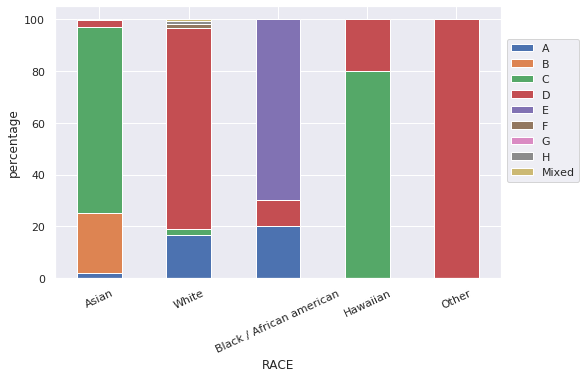

In [164]:
df_stack.apply(lambda row: row / race_sum * 100).plot(kind='bar', stacked=True, figsize=(8,5))
plt.xticks(rotation=25)
plt.ylabel("percentage")
plt.gca().legend(bbox_to_anchor=(1,0.9))

df_stack.plot(kind='bar', stacked=True)
plt.xticks(rotation=45)
plt.ylabel("counts");

In [22]:
custom_palette = []
print(sns.color_palette())
custom_palette.append(sns.color_palette()[2])
custom_palette.append(sns.color_palette()[3])
custom_palette.append(sns.color_palette()[1])
custom_palette.append(sns.color_palette()[0])
custom_palette.append(sns.color_palette()[4])
custom_palette.append(sns.color_palette()[8])
custom_palette.append(sns.color_palette()[7])
custom_palette.append(sns.color_palette()[6])

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (1.0, 0.4980392156862745, 0.054901960784313725), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313), (0.8392156862745098, 0.15294117647058825, 0.1568627450980392), (0.5803921568627451, 0.403921568627451, 0.7411764705882353), (0.5490196078431373, 0.33725490196078434, 0.29411764705882354), (0.8901960784313725, 0.4666666666666667, 0.7607843137254902), (0.4980392156862745, 0.4980392156862745, 0.4980392156862745), (0.7372549019607844, 0.7411764705882353, 0.13333333333333333), (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]


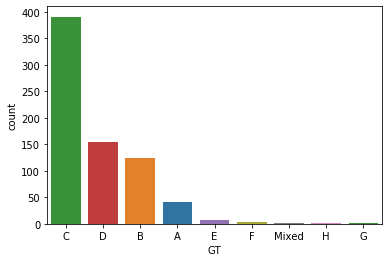

In [23]:
sns.countplot(x='GT', data=df_clinical, order=GTs, palette=custom_palette);

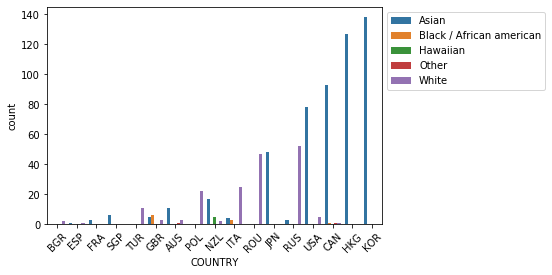

In [62]:
sns.countplot(x='COUNTRY', data=df_clinical, hue='RACE', order=order[-1::-1])
plt.xticks(rotation=45);
plt.gca().legend(bbox_to_anchor=(1,1));

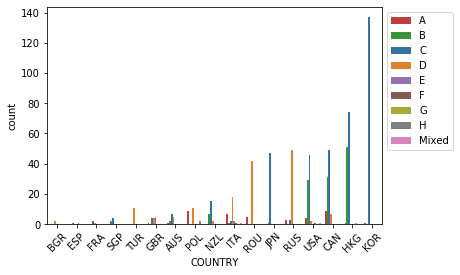

In [96]:
sns.countplot(x='COUNTRY',  data=df_clinical, hue='GT', order=order[-1::-1], palette=gt_palette)
plt.xticks(rotation=45);
plt.gca().legend(bbox_to_anchor=(1,1));

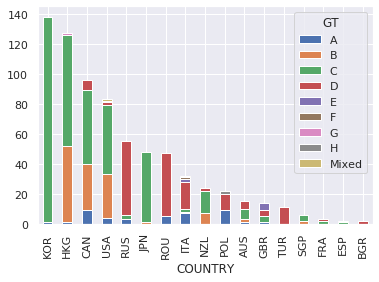

In [150]:
df_stack = df_clinical.groupby(['COUNTRY', 'GT']).size().reset_index().pivot(columns='GT', index='COUNTRY', values=0)
df_stack = df_stack.loc[df_clinical.COUNTRY.value_counts().index.values]
df_stack.plot(kind='bar', stacked=True)

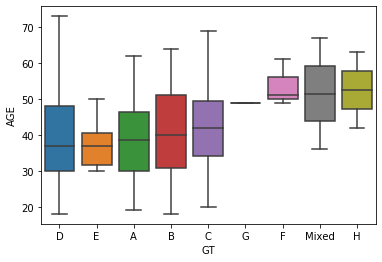

In [99]:
sns.boxplot(x='GT', y='AGE', data=df_clinical, order=df_gt_age.index.values);

# Viral data

Description of dataset:
* 1613 positions (which corresponds to the sum of the protein sizes defined [here](https://www.uniprot.org/uniprot/?query=GQ924620&sort=score), by adding 4, which is the number of stop codons)
* 5394 variants
* 790 individuals

**ALL PLOTS BELOW ARE FROM RAW DATA**, until something is mentionned.

In [4]:
df_aa = pd.read_csv(PATH_VIRAL_RAW_DATA, sep='\s+')

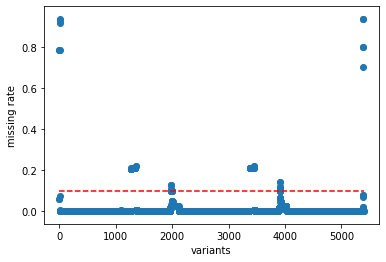

In [5]:
plt.scatter(x=range(df_aa.shape[1]), y=1-df_aa.count()/df_aa.shape[0]);
plt.plot([0,df_aa.shape[1]], [INDIVIDUALS_THRESHOLD_MAX_MISSING, INDIVIDUALS_THRESHOLD_MAX_MISSING], '--r');
plt.xlabel("variants"); plt.ylabel("missing rate");

We see that the missing values are reassuringly not homogeneously distributed, they occur at specific positions in the genome. Keep in mind tha the points very close to each other are probably on the same residue, but are different variants for that residue. (TODO ? Cross this information with the overlapping of HBV genes). Only 181 (out of 5393) have a missing rate > 10%. 

TODO : show mutation rate of raw data and of clean data (actually show be the same since mean() ignores NANs)

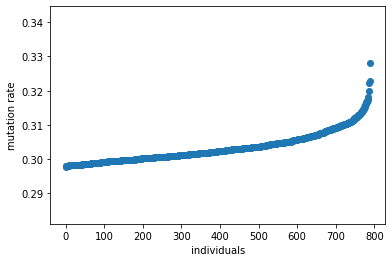

In [16]:
# Mutation rate per individual
mut_rate_inds = df_aa.mean(axis=1)
plt.scatter(x=range(len(mut_rate_inds)), y=sorted(mut_rate_inds));
plt.xlabel("individuals"); plt.ylabel("mutation rate");

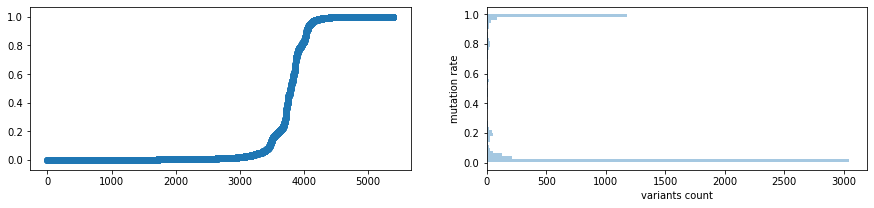

In [32]:
mut_rate_vars = df_aa.mean(axis=0)
fig, ax = plt.subplots(1,2, figsize=(15, 3))
ax[0].scatter(x=range(len(mut_rate_vars)), y=sorted(mut_rate_vars))
sns.distplot(mut_rate_vars, ax=ax[1], kde=False, bins=50, vertical=True)
ax[1].set_xlabel("variants count"); ax[1].set_ylabel("mutation rate");

In [84]:
df_viral_gt = df_aa.join(other=df_clinical.set_index('gilead_id')[['GT']])

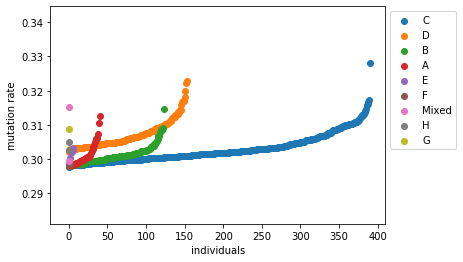

In [86]:
GTs = df_viral_gt.GT.value_counts().index.values
for gt in GTs :
    df_sub = df_viral_gt[df_viral_gt.GT == gt]
    mut_per_ind = df_sub.mean(axis=1)
    plt.scatter(y=range(len(mut_per_ind)), x=sorted(mut_per_ind), label=gt)
plt.legend(bbox_to_anchor=(1,1));
plt.xlabel("individuals"); plt.ylabel("mutation rate");

Let's do the same with the clean data

In [5]:
with open(PATH_VIRAL_DATA, 'rb') as file:
    df_viral = pickle.load(file).set_index('id')
tmp = df_clinical.set_index('gilead_id')[['GT']]
tmp.columns = pd.MultiIndex.from_product( [['clinical'], ['GT'], ['']])
df_viral_gt = df_viral.join(other=tmp)
tmp = None

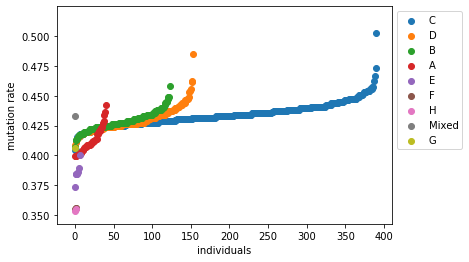

In [6]:
GTs = df_viral_gt[('clinical', 'GT')].value_counts().index.values
for gt in GTs :
    df_sub = df_viral_gt[df_viral_gt[('clinical', 'GT', '')] == gt].drop(('clinical', 'GT', ''), axis=1)
    mut_per_ind = df_sub.mean(axis=1)
    plt.scatter(x=range(len(mut_per_ind)), y=sorted(mut_per_ind), label=gt)
plt.legend(bbox_to_anchor=(1,1));
plt.xlabel("individuals"); plt.ylabel("mutation rate");

### Quality control report

1. 181 variants with > 10% missingness dropped, remains 5212
1. 1 individual with > 10% missingness dropped, remains 789
1. 4468 variants with <5% or >95% frequency, remains 744


## PCA viral data


In [11]:
# 1. Load data
with open(PATH_CLINICAL_DATA, 'rb') as file:
    # Keep relevant variables, set index
    df_clinical = pickle.load(file)[VIRAL_CLINICAL_VARIABLES].set_index('gilead_id')
with open(PATH_VIRAL_DATA, 'rb') as file:
    # Set index
    df_viral = pickle.load(file).set_index('id')
# 2. Prepare index structure for merging
df_clinical.columns = pd.MultiIndex.from_product( [ ['clinical'], df_clinical.columns, [''] ] )
# 3. Join the tables on the indexes
df_merge = df_viral.join(other=df_clinical)

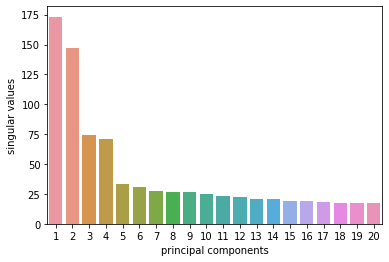

<Figure size 720x216 with 0 Axes>

In [16]:
pcs, data = viral_seq.pca_impute(df_merge.drop('clinical', axis=1), impute_strategy='mean', n_components=20)
common.plot_pca(pcs, data, pc_plot_height=None, n_plots=0);

<Figure size 432x288 with 0 Axes>

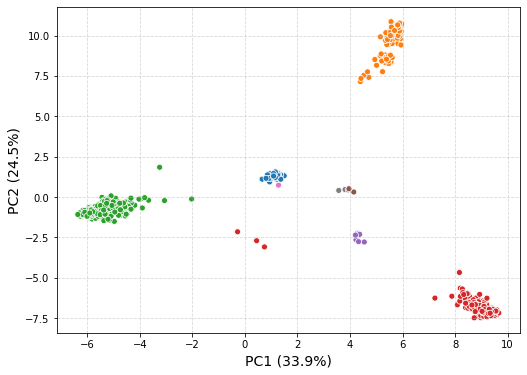

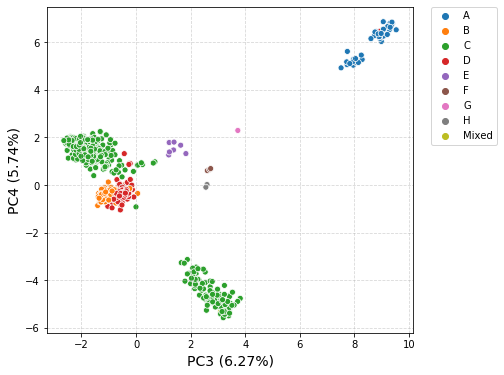

In [103]:
common.plot_pca(pcs, data, pc_plot_height=6, bbox_to_anchor=(1.05,1), singular_values=False,
                n_plots=2, scaled_only=True, hue=df_merge[('clinical','GT','')].values)

In [9]:
df_merge[('clinical', 'RACE', '')].cat.rename_categories({'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER':'Hawaiian', 'ASIAN':'Asian',
                                       'WHITE':'White', 'BLACK OR AFRICAN AMERICAN':'Black / African american',
                                       'OTHER':'Other', }, 
                                       inplace=True)

NameError: name 'df_merge' is not defined

<Figure size 432x288 with 0 Axes>

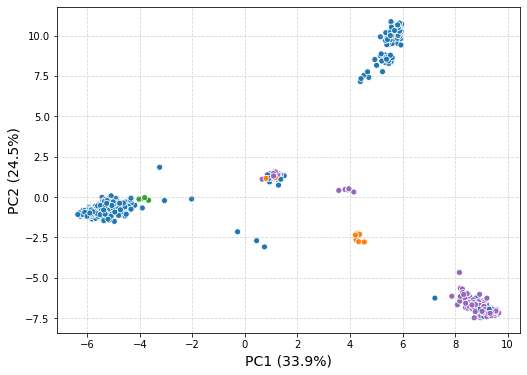

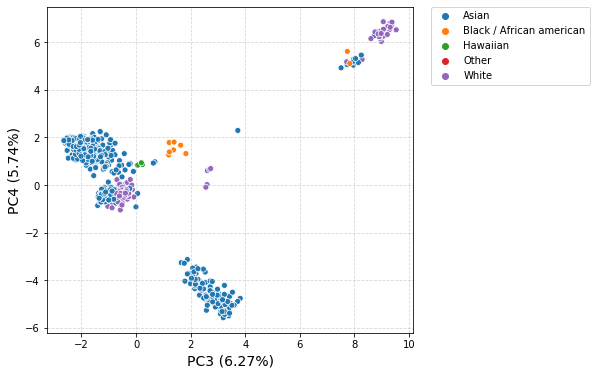

In [112]:
common.plot_pca(pcs, data, pc_plot_height=6, bbox_to_anchor=(1.05,1), singular_values=False,
                n_plots=2, scaled_only=True, hue=df_merge[('clinical','RACE','')].values)

# Host exome data



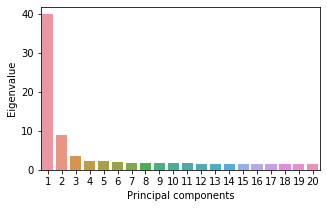

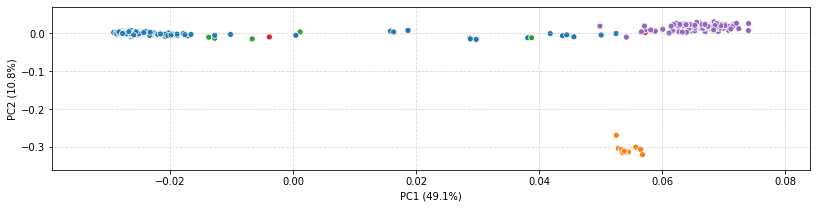

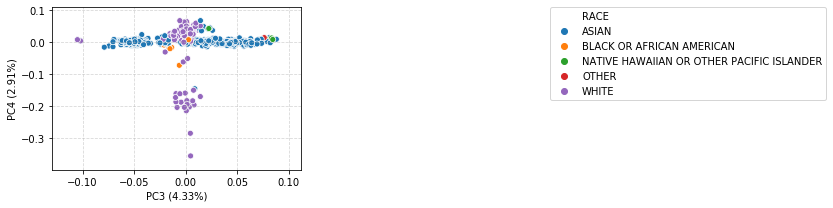

In [14]:
host.plot_plink_pca(PATH_HOST_CLEAN_DATA, n_pcs=4, hue_col='RACE',
                   bbox_to_anchor=(2, 1))

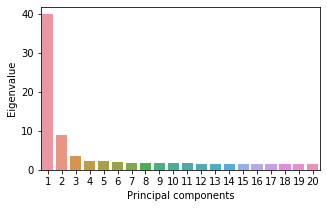

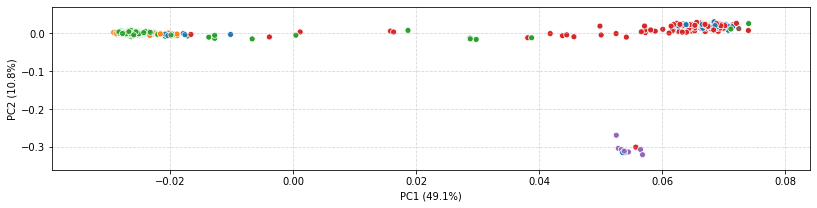

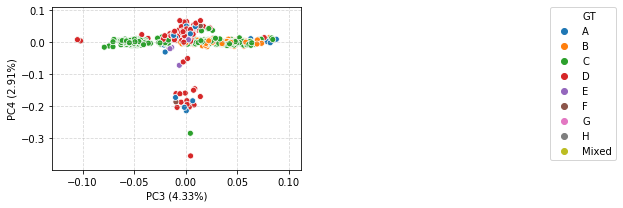

In [15]:
host.plot_plink_pca(PATH_HOST_CLEAN_DATA, n_pcs=4, hue_col='GT',
                   bbox_to_anchor=(2, 1))

## Asian subset - Quality control diagram

1. Raw data
1. Asian subset
1. Preprocessed subset
1. 

([0, 1, 2, 3, 4, 5], <a list of 6 Text xticklabel objects>)

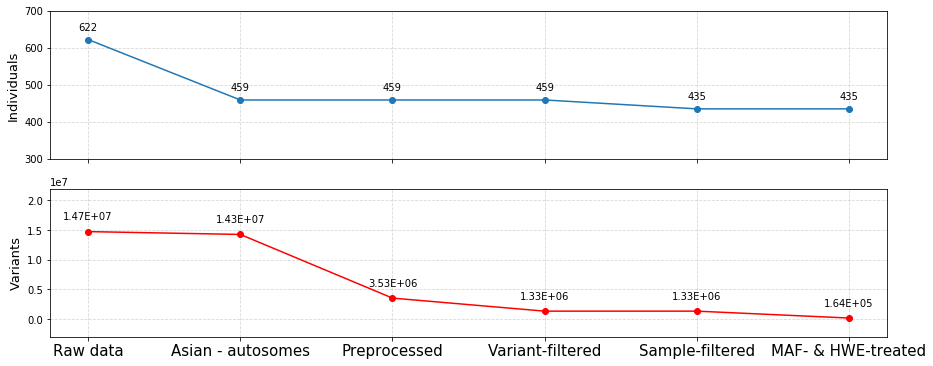

In [98]:
names = ['Raw data', 'Asian - autosomes', 'Preprocessed', 'Variant-filtered', 
         'Sample-filtered', 'MAF- & HWE-treated']
individuals = [622, 459, 459, 459, 435, 435]
variants = [14_738_460, 14_260_418, 3_526_894, 1_326_310, 1_326_310, 164_183]

fig, ax = plt.subplots(2, 1, figsize=(15,6), sharex=True)
ax[0].plot(names, individuals, 'o-')
ax[0].set_ylabel("Individuals")
ax[0].grid(linestyle='--', alpha=0.5)
ax[0].set_ylim([300, 700])
ax[1].plot(names, variants, 'ro-')
ax[1].set_ylabel("Variants")
ax[1].grid(linestyle='--', alpha=0.5)
ax[1].set_ylim([-3e6, 2.2e7])
plt.rc('axes', labelsize=13)
plt.rc('xtick', labelsize=15)
for i, v in enumerate(individuals):
    ax[0].text(i, v+25, "%d" %v, ha="center")
for i, v in enumerate(variants):
    ax[1].text(i, v+0.2e7, "{:.2E}".format(v), ha="center")
#plt.subplots_adjust(hspace=1.2)
plt.xticks(rotation=0)

# G2G Results



In [3]:
df_results = pd.read_csv(PATH_GWAS_FINAL_RESULTS, sep='\t')

In [7]:
# Slide printscreen format
df_results

,ID,#CHROM,POS,REF,ALT,A1,TEST,OBS_CT,OR,LOG(OR)_SE,Z_STAT,P,AA
0,rs2296651,14,70245193,G,A,A,ADD,434,4.814160e+01,0.560362,6.91365,4.723260e-12,S_35_R
1,rs9397998,6,157488340,C,T,T,ADD,431,1.711340e+09,2.891680,7.35232,1.947920e-13,Pol_584_T
2,rs70944751,6,29911857,G,T,T,ADD,430,4.000960e-02,0.490586,-6.56080,5.352000e-11,PC_160_A
3,rs376806238,6,29912395,T,TGG,TGG,ADD,413,5.556070e-03,0.793047,-6.54799,5.831780e-11,PC_160_A
4,rs2735101,6,29913001,T,C,C,ADD,429,1.258320e-02,0.669145,-6.53878,6.202110e-11,PC_160_A


In [105]:
df_show = df_results[['ID', '#CHROM', 'P', 'AA']].set_index('ID')
df_show.index.name = ""
types = ['SLC10A1 missense mutation', 'ARID1B intronic variant', 'HLA-A intronic variant', 'HLA-A non coding transcript variant', 'HLA-A intronic variant']
df_show.insert(loc=0, column='Type', value=types)
df_show

,Type,#CHROM,P,AA
,,,,
rs2296651,SLC10A1 missense mutation,14,4.723260e-12,S_35_R
rs9397998,ARID1B intronic variant,6,1.947920e-13,Pol_584_T
rs70944751,HLA-A intronic variant,6,5.352000e-11,PC_160_A
rs376806238,HLA-A non coding transcript variant,6,5.831780e-11,PC_160_A
rs2735101,HLA-A intronic variant,6,6.202110e-11,PC_160_A


# Questions

###### Why majority of the SNPs are biallelic ?

Book primer to genome science. What could be the actual quesion ? 